#Classification from video frames

> Connecting notebook to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> Changing to Working directory

In [2]:
%cd drive/MyDrive/assignment/

/content/drive/MyDrive/assignment


> Required Imports

In [112]:
# import data processing and visualisation libraries
import numpy as np
import glob
import matplotlib.pyplot as plt
import os, shutil
%matplotlib inline

# imports for image processing
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# imports for training 
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.random import set_seed

# Functions for scripting tasks
from helper_functions import get_frames, prepare_image, display_batch

> Creating **training set** and **validation set**

In [4]:
# Random Seed
set_seed(42)

IMG_SIZE = (224, 224)
BATCH_SIZE = 128

# Data Paths
train_dir = 'dataset'

# Creating a Data Generator
data_gen = ImageDataGenerator(validation_split=0.2,rescale=1./255)

train_dataset = data_gen.flow_from_directory(train_dir,
                                          target_size=IMG_SIZE,  # all images will be resized to 224x224
                                          batch_size=BATCH_SIZE, 
                                          subset="training")
validation_dataset = data_gen.flow_from_directory(train_dir,
                                        target_size=IMG_SIZE,  # all images will be resized to 224x224
                                        batch_size=BATCH_SIZE, 
                                        subset="validation")

# Classes
class_names = list(train_dataset.class_indices.keys())
NUM_CLASSES = len(class_names)

Found 1334 images belonging to 3 classes.
Found 331 images belonging to 3 classes.


> Classes in our dataset

In [5]:
class_names

['electric bus', 'electric car', 'human']

> Displaying Batch of images

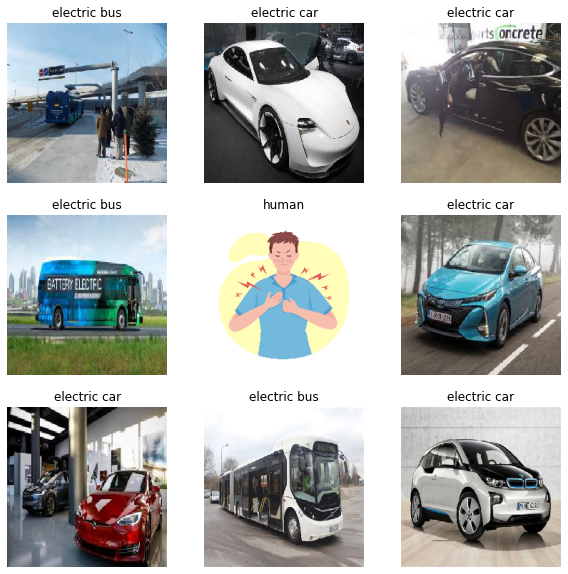

In [6]:
display_batch(train_dataset, class_names)

> Defining the `model` Architechture.

Here were are using 4 pairs for `Conv2D` and `MaxPooling2D`, `Flatten`, 6 pairs of `Dense` and `Dropout` and finally `Dense` layer with `softmax` activation function with 3 `units`.

In [7]:

IMG_SHAPE = IMG_SIZE + (3,)
model = keras.models.Sequential([
        keras.layers.Conv2D(32, 7, activation="relu", padding="same",
                            input_shape=IMG_SHAPE),
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
        keras.layers.MaxPooling2D(2),
        
        keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
        keras.layers.MaxPooling2D(2),

        keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
        keras.layers.MaxPooling2D(2),

        keras.layers.Flatten(),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(3, activation="softmax")
])

> Compiling the `model`

Here we use:<br>
`rmsprop` as `optimizer`<br>
`categorical_crossentropy` as `loss`<br>
`accuracy` as `metric`



In [8]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
    )

> Creating callbacks to save model and stop training when model is not improving or loss is getting worse.

In [9]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "detection_modelV3.h5",
    save_best_only=True
    )

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
    )

callbacks = [checkpoint_cb, early_stopping_cb]

> Training the model

In [10]:
"""
model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks = callbacks
    )

results = model.evaluate(validation_dataset)
"""

'\nmodel.fit(\n    train_dataset,\n    epochs=100,\n    validation_data=validation_dataset,\n    callbacks = callbacks\n    )\n\nresults = model.evaluate(validation_dataset)\n'

> Evaluating model on the `validation_set`

In [11]:
model.evaluate(validation_dataset)

3/3 [==============================] - 28s 9s/step - loss: 1.1013 - accuracy: 0.1118


[1.1012816429138184, 0.11178247630596161]

> Loading our saved model "***detection_modelV3.h5***" and displaying model architechture.

In [12]:
model = load_model('detection_modelV3.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      4736      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 128)     

## Working with videos.

### First Video
Youtube Link: [Video 1](https://youtu.be/ZL34IBhn7pw)

> Extracting frames from our **first video** which is 12.54 mins long.<br> Frames are extracted at 24 frames/sec rate.

In [13]:
vid_path = "./videos/video1.mp4"
vid1_dir = get_frames(vid_path)

Path already exists.
Please delete the existing folder and return get_frames again.
./video1


In [14]:
# def prepare_image(path):
#     img = np.array(load_img(path).resize((224,224)))
#     return img

> Function to convert our frames into `numpy.array` of shape `(num_of_frames, height, weight, channels)`

In [15]:
def load_images(dir_name):
    image_set = [ prepare_image(image_name) for image_name in glob.glob(f"{dir_name}/*.jpg")]
    result = np.array(image_set)
    print(result.shape)
    return result

In [16]:
image_set = load_images(vid1_dir)

(19368, 224, 224, 3)


> Making predictions using our `image_set`. 

In [17]:
predictions = model.predict(image_set)
predictions.shape

(19368, 3)

In [109]:
def filter_frames(predictions, th = 0.9):
    class_names = ["electric car", "electric bus", "human"]
    filtered = {"index":[], "class":[]}
    for i, prediction in enumerate(predictions):
        class_ = class_names[prediction.argmax()]
        prob = prediction[prediction.argmax()]
        if (prob >= 0.3 and class_ == "human") or (class_ == "electric car" and prob >= th) or (class_ == "electric bus" and prob >= th):
            filtered["index"].append(i)
            filtered["class"].append(class_)
            if i % 500 == 0 and i != 0:
                start = filtered["index"][0]/24
                end = filtered["index"][-1]/24
                classes = list(set(filtered["class"]))
                print(f"From {start}s to {end}: {classes}")
                filtered = {"index": [],
                    "class": []}

In [106]:
filter_frames(predictions)

From 0.0s to 20.833333333333332: ['human', 'electric bus', 'electric car']
From 20.875s to 41.666666666666664: ['human', 'electric bus', 'electric car']
From 41.708333333333336s to 62.5: ['human', 'electric bus', 'electric car']
From 62.541666666666664s to 83.33333333333333: ['human', 'electric bus', 'electric car']
From 83.375s to 104.16666666666667: ['human', 'electric bus', 'electric car']
From 104.20833333333333s to 125.0: ['human', 'electric bus', 'electric car']
From 125.04166666666667s to 145.83333333333334: ['human', 'electric bus', 'electric car']
From 145.875s to 166.66666666666666: ['human', 'electric bus', 'electric car']
From 166.70833333333334s to 187.5: ['human', 'electric bus', 'electric car']
From 187.54166666666666s to 208.33333333333334: ['human', 'electric bus', 'electric car']
From 208.375s to 229.16666666666666: ['human', 'electric bus', 'electric car']
From 229.20833333333334s to 250.0: ['human', 'electric bus', 'electric car']
From 250.04166666666666s to 270.833

### Second Video
Youtube Link: [Video 2](https://youtu.be/zg5wGw4AQ4M)

> Extracting frames from our **first video** which is 3.56 mins long.<br> Frames are extracted at 24 frames/sec rate.

In [21]:
vid2_path = "./videos/video2.mp4"
vid2_dir = get_frames(vid2_path)

In [22]:
image_set2 = load_images(vid2_dir)

(5921, 224, 224, 3)


In [23]:
predictions2 = model.predict(image_set2)

In [110]:
filter_frames(predictions2)

From 0.0s to 20.833333333333332: ['human', 'electric bus', 'electric car']
From 20.875s to 41.666666666666664: ['electric bus', 'electric car']
From 41.708333333333336s to 62.5: ['human', 'electric bus', 'electric car']
From 62.541666666666664s to 83.33333333333333: ['electric bus', 'electric car']
From 83.375s to 104.16666666666667: ['human', 'electric bus', 'electric car']
From 104.20833333333333s to 125.0: ['human', 'electric bus', 'electric car']
From 125.04166666666667s to 145.83333333333334: ['human', 'electric bus', 'electric car']
From 145.875s to 166.66666666666666: ['electric bus', 'electric car']
From 166.70833333333334s to 187.5: ['human', 'electric bus', 'electric car']
From 187.54166666666666s to 208.33333333333334: ['electric bus', 'electric car']
From 208.375s to 229.16666666666666: ['human', 'electric bus', 'electric car']


End of the Notebook.